In [144]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
import pickle

In [2]:
DF=pd.read_csv("data.csv")
df=DF.copy()

In [3]:
df['PIPI']=1-df['Disposable_Income']/df['Income']
expense_cols = [
    "Rent","Loan_Repayment","Insurance","Groceries","Transport",
    "Eating_Out","Entertainment","Utilities","Healthcare",
    "Education","Miscellaneous"
]

df["num_expense_categories_used"] = (df[expense_cols] > 0).sum(axis=1)

# Fixed vs flexible category counts
fixed_cols = ["Rent","Loan_Repayment","Insurance"]
flexible_cols = ["Eating_Out","Entertainment","Miscellaneous"]

df["num_fixed_categories"] = (df[fixed_cols] > 0).sum(axis=1)
df["num_flexible_categories"] = (df[flexible_cols] > 0).sum(axis=1)

In [4]:
numeric_features = [
    "Income",
    "Age",
    "Dependents",
    "Desired_Savings_Percentage",
    "num_expense_categories_used",
    "num_fixed_categories",
    "num_flexible_categories",
    "Potential_Savings_Groceries",
    "Potential_Savings_Transport",
    "Potential_Savings_Eating_Out",
    "Potential_Savings_Entertainment",
    "Potential_Savings_Utilities",
    "Potential_Savings_Healthcare",
    "Potential_Savings_Education",
    "Potential_Savings_Miscellaneous"
]

categorical_features = ["Occupation", "City_Tier"]

categorical_features = ["Occupation","City_Tier"]

X = df[numeric_features + categorical_features]
y = df["PIPI"]

In [118]:
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.2,random_state=34)
preprocessor=ColumnTransformer([
    ('scaler',StandardScaler(),numeric_features),
    ('onehotEncoding',OneHotEncoder(handle_unknown="ignore",sparse_output=False),[categorical_features[0]])
    ,('ordinalEncoding',OrdinalEncoder(categories=[['Tier_3','Tier_2','Tier_1']]),[categorical_features[1]])
])

In [119]:
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
pipe=Pipeline(steps=[
    ("preprocess",preprocessor),
    ("model",model)])


In [120]:
pipe.fit(X_train,Y_train)
y_pred=pipe.predict(X_test)

In [121]:
mae = mean_absolute_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

MAE: 0.0321
R² Score: 0.8272


In [122]:
with open("model.pkl", "wb") as file:
    pickle.dump(pipe, file)

In [123]:
X_test_transformed=pipe["preprocess"].transform(X_test)
occ_features=pipe["preprocess"]["onehotEncoding"].get_feature_names_out(['Occupation'])
feature_names=numeric_features+list(occ_features)+["City_Tier"]
X_test=X_test.reset_index(drop=True)

In [17]:
import shap
shap.initjs()
explainer=shap.TreeExplainer(pipe["model"],pipe["preprocess"].fit_transform(X_train))
shap_values=explainer.shap_values(pipe["preprocess"].transform(X_test))

100%|===================| 3982/4000 [03:47<00:01]        

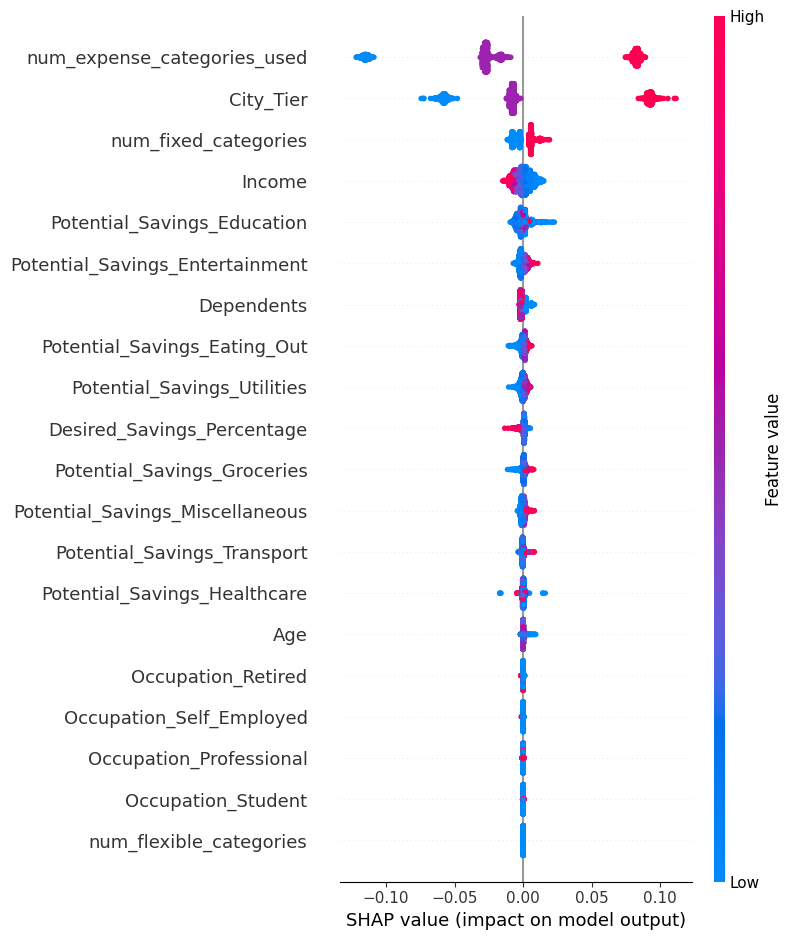

In [29]:
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names
)

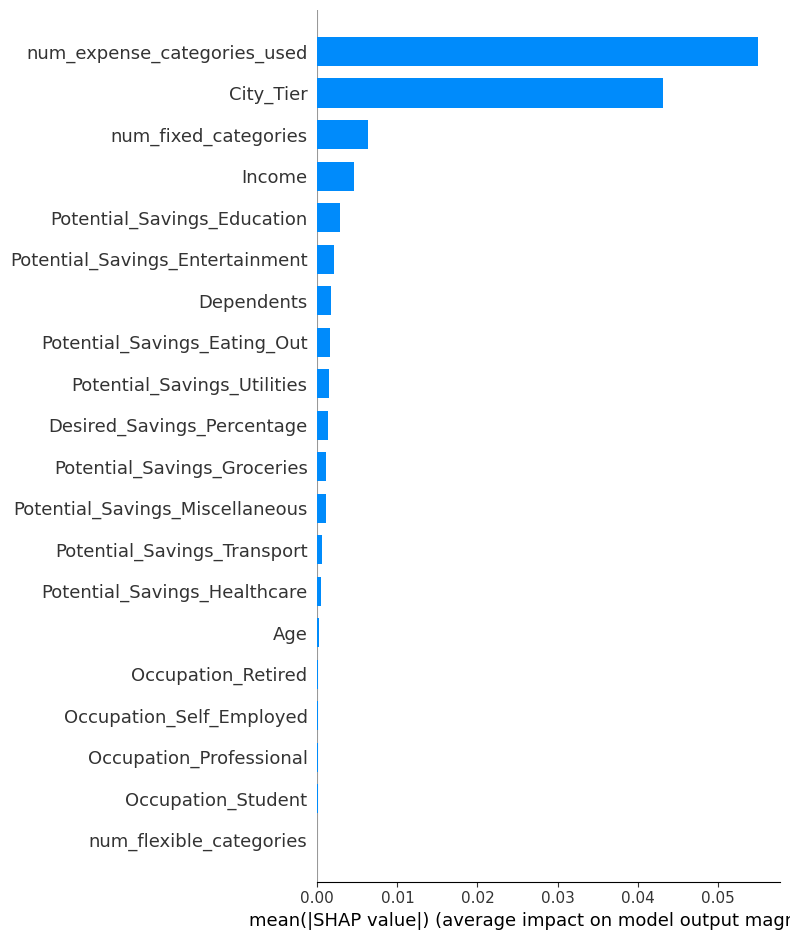

In [30]:
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names,
    plot_type="bar"
)

In [124]:
occ_features.shape

(4,)

In [133]:
ohe = pipe["preprocess"].named_transformers_["onehotEncoding"]
X_test_1 = ohe.transform(X_test[[categorical_features[0]]])
X_test_1_df = pd.DataFrame(
    X_test_1,
    columns=occ_features,
    index=X_test.index
)
X_test_ohe = pd.concat([X_test, X_test_1_df], axis=1)
X_test_ohe=X_test_ohe.drop(columns=[categorical_features[0]],axis=1)
X_test_ohe.shape

(4000, 20)

In [142]:
i = 87  # any index
#explainer=shap.TreeExplainer(pipe["model"],pipe["preprocess"].fit_transform(X_train))
#shap_values=explainer.shap_values(pipe["preprocess"].transform(X_test))
#shap_values=explainer.shap_values(pipe["preprocess"].transform(X_test))
shap.force_plot(
    explainer.expected_value,
    shap_values[i],
     X_test_ohe.iloc[i,:],
    feature_names=feature_names
)

In [143]:
df.describe()

,Income,Age,Dependents,Rent,Loan_Repayment,Insurance,Groceries,Transport,Eating_Out,Entertainment,...,Potential_Savings_Eating_Out,Potential_Savings_Entertainment,Potential_Savings_Utilities,Potential_Savings_Healthcare,Potential_Savings_Education,Potential_Savings_Miscellaneous,PIPI,num_expense_categories_used,num_fixed_categories,num_flexible_categories
count,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.0
mean,4.158550e+04,41.031450,1.995950,9115.494629,2049.800292,1455.028761,5205.667493,2704.466685,1461.856982,1448.853658,...,254.963280,254.031058,436.332808,41.524964,62.417083,144.904987,0.744878,10.195400,2.398450,3.0
std,4.001454e+04,13.578725,1.417616,9254.228188,4281.789941,1492.938435,5035.953689,2666.345648,1481.660811,1489.019270,...,296.047943,299.973590,503.200658,53.152458,98.842656,169.160951,0.097190,0.633592,0.489591,0.0
min,1.301187e+03,18.000000,0.000000,235.365692,0.000000,30.002012,154.078240,81.228584,39.437523,45.421469,...,3.797926,3.121610,6.200297,0.001238,0.000000,2.091973,0.493496,9.000000,2.000000,3.0
25%,1.760488e+04,29.000000,1.000000,3649.422246,0.000000,580.204749,2165.426419,1124.578012,581.011801,581.632906,...,84.506870,84.562090,148.013618,11.037421,4.926210,47.637307,0.672324,10.000000,2.000000,3.0
50%,3.018538e+04,41.000000,2.000000,6402.751824,0.000000,1017.124681,3741.091535,1933.845509,1029.109726,1020.198376,...,164.927660,164.740232,285.739582,25.202124,33.127987,93.090257,0.735113,10.000000,2.000000,3.0
75%,5.176545e+04,53.000000,3.000000,11263.940492,2627.142320,1787.160895,6470.892718,3360.597508,1807.075251,1790.104082,...,313.398240,310.927935,538.983703,52.353736,80.946145,178.257981,0.810292,11.000000,3.000000,3.0
max,1.079728e+06,64.000000,4.000000,215945.674703,123080.682009,38734.932935,119816.898124,81861.503457,34406.100166,38667.368308,...,5573.036433,6222.200913,8081.799518,1394.531049,3647.244243,4637.951137,1.062378,11.000000,3.000000,3.0


In [149]:
def inflation_risk_band(score):
    if score < 0.30:
        return "Low Inflation Pressure"
    elif score < 0.60:
        return "Moderate Inflation Pressure"
    else:
        return "High Inflation Pressure"

df["Result_PIPI"]=df["PIPI"].apply(inflation_risk_band)
df["Result_PIPI"].value_counts()

Result_PIPI
High Inflation Pressure        19034
Moderate Inflation Pressure      966
Name: count, dtype: int64